In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

data = pd.read_csv('../input/titanic/train.csv')

print(data.info())
data.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


,number,rate
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,0.198653
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


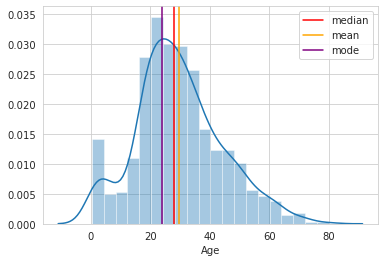

In [3]:
# Detect null value 

null = data.isna().sum()
null_rate = null/data.shape[0]
Null_value= pd.DataFrame(pd.concat([null,null_rate],axis=1))
Null_value.columns=['number','rate']
display(Null_value)
# Embarked has only two null values, so it can be filled by mode as it is categorical variable 
data['Embarked'].fillna(value=data['Embarked'].mode()[0],inplace=True)
# Age has nearly 20% of null values, to unsure the accuracy of model prediction, I create a new column to label null values
data['Unknown_age']=[1 if i!= i else 0 for i in data['Age']]

fig=sns.distplot(data['Age'])
plt.axvline(data['Age'].median(),color='red',label='median')
plt.axvline(data['Age'].mean(),color='orange',label='mean')
plt.axvline(data['Age'].mode()[0],color='purple',label='mode')
plt.legend()


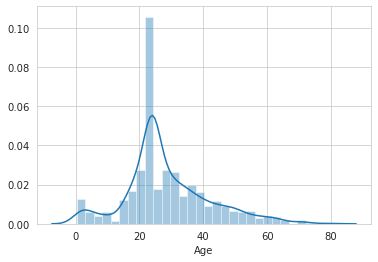

In [4]:
# As Age is slightly right unbaised, fill null values with mode, so that the Age distribution is near normal distribution
data['Age'].fillna(data['Age'].mode()[0],inplace=True)
fig = sns.distplot(data['Age'])


In [5]:
# Cabin has 77% of null value 
data['Unknown_cabin']=[1 if i != i else 0 for i in data['Cabin']]
data['Cabin'].value_counts(sort=True, ascending=False)
# fill NaN with U  to label missing values 
data['Cabin'].fillna('U',inplace=True)

data.isna().any()

PassengerId      False
Survived         False
Pclass           False
Name             False
Sex              False
Age              False
SibSp            False
Parch            False
Ticket           False
Fare             False
Cabin            False
Embarked         False
Unknown_age      False
Unknown_cabin    False
dtype: bool

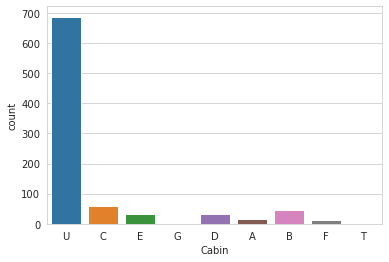

In [6]:
# some none numercial vairables to be transform to numerical variable
import re 

def find(series):
    result=re.search('[a-zA-Z]',series).group()
    return result

cabin =data['Cabin'].apply(find)
data['Cabin']= cabin
ccp = sns.countplot(data['Cabin'])



Mr.        517
Miss.      182
Mrs.       125
Master.     40
Other       27
Name: Name, dtype: int64

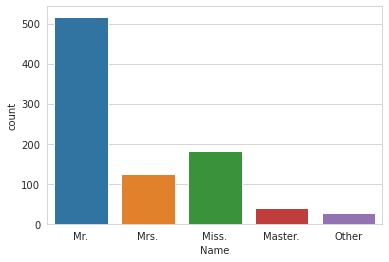

In [7]:

data['Name']=data['Name'].apply(lambda x: re.search('[\,a-zA-Z]+\.',x).group())
data['Name']=data['Name'].replace(['Dr.','Rev.','Mlle.','Col.','Major.','Sir.','Don.','Countess.','Mme.','Ms.','Lady.','Capt.','Jonkheer.'],'Other')
name= data['Name'].value_counts()
fig1 = sns.countplot(x=data['Name'])


name
# Male passengers are in the largest proportion

In [8]:
# sex ,ticket 
data['Sex']=data['Sex'].map({'male':1,'female':0})
ticket_type =data['Ticket'].apply(lambda x: re.match('[a-zA-Z+]*',x).group())
# To avoid the outlier, replaced some minorities variables with same type 7
ticket_mapping = {'':1,'PC':2,'C':3,'A':4,'STON':5,'SOTON':6,'CA':7,'S':7,'SC':7,'W':7,'F':7,'LINE':7,'PP':7,'WE':7,'SW':7,'SCO':7,'SO':7,'FA':7}
ticket_type.value_counts()
data['Ticket']=ticket_type.map(ticket_mapping)


In [9]:
data['Ticket'].fillna(value=1,inplace=True)

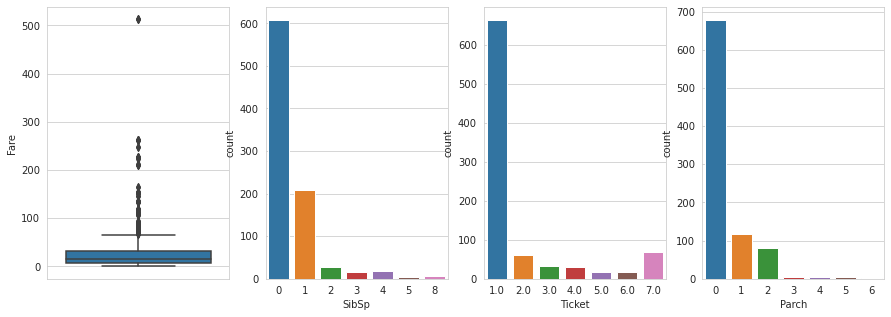

In [10]:
# Fare ,sibling and parent child,
fig,ax=plt.subplots(1,4)
fig.set_size_inches(15,5)
fbp = sns.boxplot(y=data['Fare'],ax=ax[0])
scp = sns.countplot(x= data['SibSp'],ax=ax[1])
tcp = sns.countplot(x=data['Ticket'],ax=ax[2])
pcp = sns.countplot(data['Parch'],ax=ax[3])

 



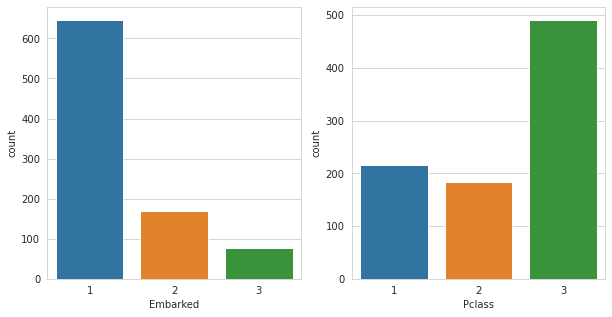

In [11]:
# Embarked, Pclass
data['Embarked']= data['Embarked'].map({'S':1,'C':2,'Q':3})
fig1,ax1=plt.subplots(1,2)
fig1.set_size_inches(10,5)
ecp = sns.countplot(data['Embarked'],ax=ax1[0])
pcp = sns.countplot(data['Pclass'],ax=ax1[1])



In [12]:
data['Name'] = data['Name'].map({'Mr.':1,'Mrs.':2,'Miss.':3,'Master.':4,'Other':5})
data['Cabin']= data['Cabin'].map({'U':1,'C':2,'B':3,'D':4,'E':5,'G':5,"A":5,'F':5,'T':5})
data['Cabin'].fillna(value=1,inplace=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Unknown_age,Unknown_cabin
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,1.804714,0.647587,28.566970,0.523008,0.381594,1.886644,32.204208,1.574635,1.361392,0.198653,0.771044
std,257.353842,0.486592,0.836071,1.095455,0.477990,13.199572,1.102743,0.806057,1.831544,49.693429,1.203827,0.635673,0.399210,0.420397
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.420000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,1.000000,0.000000,22.000000,0.000000,0.000000,1.000000,7.910400,1.000000,1.000000,0.000000,1.000000
50%,446.000000,0.000000,3.000000,1.000000,1.000000,24.000000,0.000000,0.000000,1.000000,14.454200,1.000000,1.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,3.000000,1.000000,35.000000,1.000000,0.000000,2.000000,31.000000,1.000000,2.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,5.000000,1.000000,80.000000,8.000000,6.000000,7.000000,512.329200,5.000000,3.000000,1.000000,1.000000


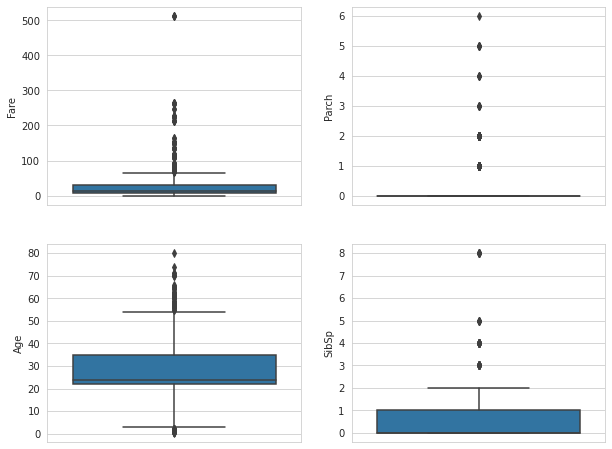

In [13]:
# Outlier detect 
display(data.describe())
# looks like Fare, Age ,Parch SibSp contain Outliers ,use boxplot to detect outlier
fig,ax = plt.subplots(2,2)
fig.set_size_inches(10,8)
fbp = sns.boxplot(y=data['Fare'],ax=ax[0,0])
abp = sns.boxplot(y=data['Age'],ax=ax[1,0])
pbp = sns.boxplot(y=data['Parch'],ax=ax[0,1])
sbp = sns.boxplot(y=data['SibSp'],ax=ax[1,1])
#  Fare,age and sibling have extreme values 

In [14]:
# use 3σ to filter out the actual value of outlier 
# Fare's outlier
F_std = data['Fare'].std()
F_mean = data['Fare'].mean()
F_outlier = data['Fare'][(data['Fare']>(F_mean+ 3*F_std))|(data['Fare']<(F_mean - 3*F_std))] 
# Age's outlier
A_std = data['Age'].std()
A_mean = data['Age'].mean()
A_outlier = data['Age'][(data['Age']>(A_mean +3*A_std))|(data['Age']<(data['Age']-3*A_std))]
# sibling and spouse
S_std = data['SibSp'].std()
S_mean = data['SibSp'].mean()
S_outlier = data['SibSp'][(data['SibSp']>(S_mean + 3*S_std))|(data['SibSp']<(S_mean-3*S_std))]
# parent and child
P_std = data['Parch'].std()
P_mean = data['Parch'].mean()
P_outlier = data['Parch'][(data['Parch']>(P_mean + 3*P_std))|(data['Parch']<(P_mean - 3*P_std))]

display(A_outlier)
# display(F_outlier)
# display(S_outlier)
display(P_outlier)

96     71.0
116    70.5
493    71.0
630    80.0
672    70.0
745    70.0
851    74.0
Name: Age, dtype: float64

13     5
25     5
86     3
167    4
360    4
437    3
438    4
567    4
610    5
638    5
678    6
736    3
774    3
858    3
885    5
Name: Parch, dtype: int64

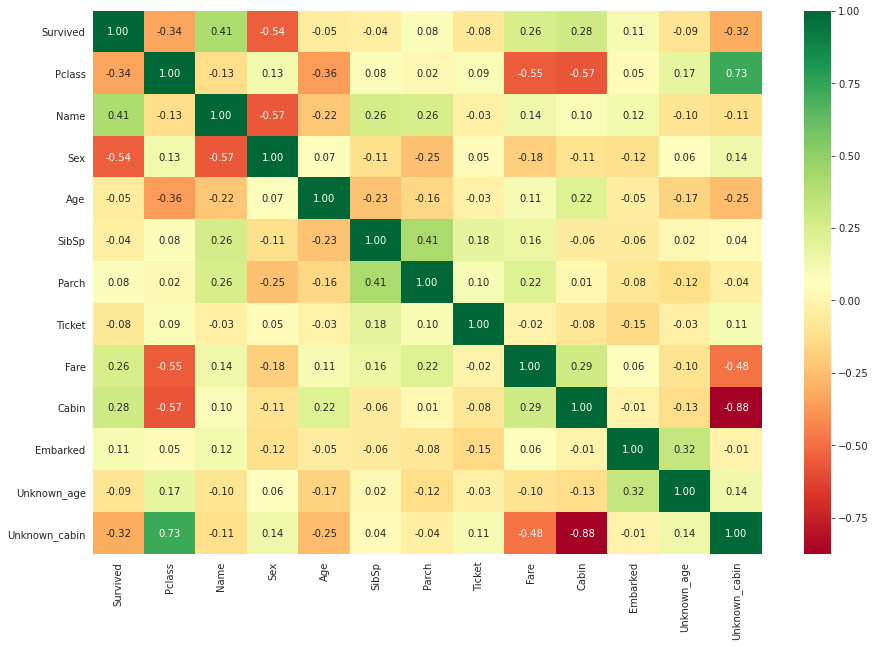

In [15]:
# let's see how each variable correlate each other  use two different parameters 
data.drop('PassengerId',axis=1,inplace=True)

correlation_p = data.corr('pearson')
correlation_s = data.corr('spearman')
plt.figure(figsize=(15,10))
heatmap_p = sns.heatmap(correlation_p, annot=True,fmt='.2f',cmap=plt.cm.RdYlGn)


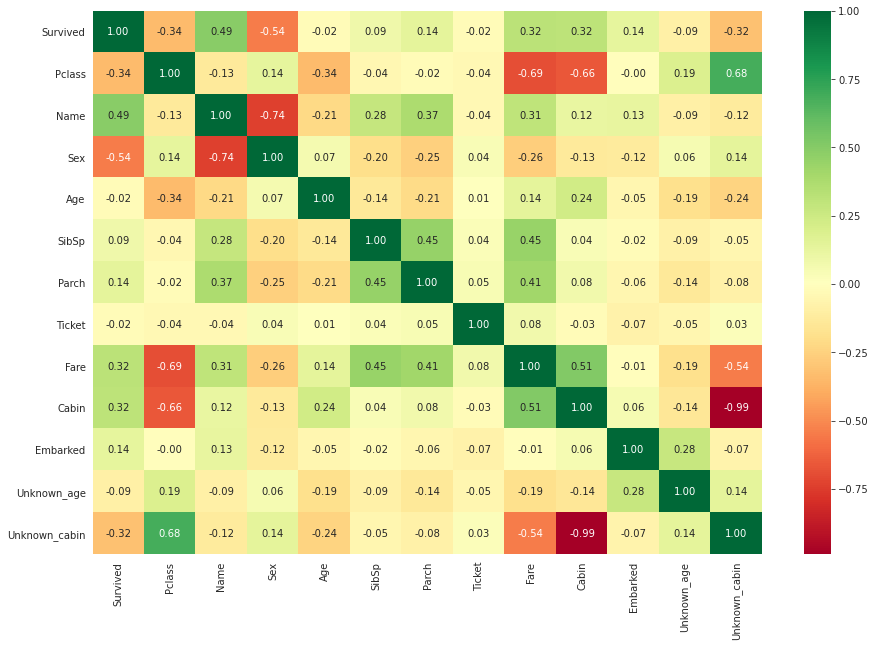

In [16]:
plt.figure(figsize=(15,10))
heatmap_s= sns.heatmap(correlation_s,annot=True,fmt='.2f',cmap=plt.cm.RdYlGn)

# spearman performs better and shows a stronger correlation among survived name and sex ,relatively low correlations among survived and  
# Fare,Cabin



Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64
Name
1    0.156673
2    0.792000
3    0.697802
4    0.575000
5    0.444444
Name: Survived, dtype: float64
Cabin
1    0.299854
2    0.593220
3    0.744681
4    0.757576
5    0.630769
Name: Survived, dtype: float64
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
Embarked
1    0.339009
2    0.553571
3    0.389610
Name: Survived, dtype: float64


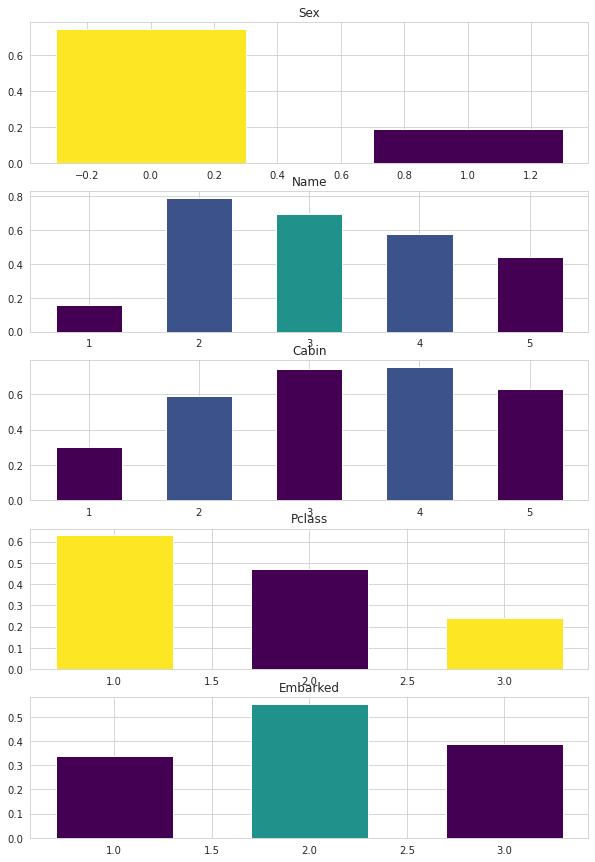

In [17]:
# How Fare affect survived 
columns= ['Sex','Name','Cabin','Pclass','Embarked']
plt.figure(figsize=(10,15))
cmp = plt.get_cmap("viridis")
rescale = lambda y: (y - y.min())/(y.max() - y.min())
for i,value in enumerate(columns,start=1):
    plt.subplot(5,1,i)
    plt.title(value)
    mean= data.groupby(value)['Survived'].mean()
    print(mean)
    plt.bar(x=mean.index,height=mean.values,width=0.6,color=cmp(rescale(data[value])))
# Women has much higher survived rate than men, 1 class passengers have highest survive rate,

In [18]:
# Age and fare are continuous variable, we will change it to categorical variables
data['Age'].describe()
data['Fare'].describe()
data['Age'].quantile(q=0.92)
data['Age'] = pd.qcut(data['Age'],q=[0,0.5,0.8,0.92,1],labels=[1,2,3,4])


In [19]:
data['Fare'].quantile(q=[0,0.25,0.5,0.75,0.85,0.95,0.99])
data['Fare'] = pd.qcut(data['Fare'],q=[0,0.5,0.75,0.9,1],labels=[1,2,3,4])



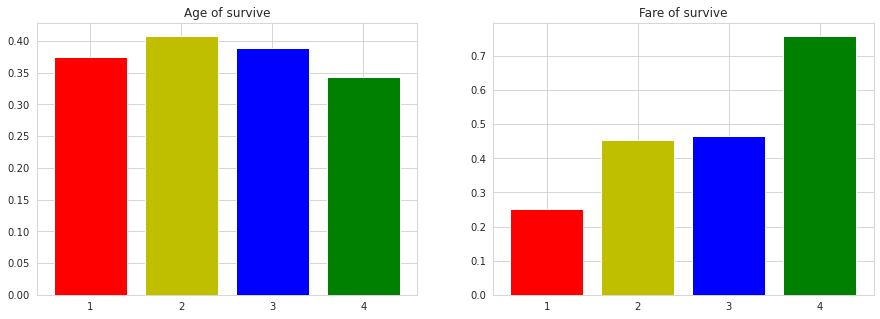

In [20]:
AS = data.groupby('Age')['Survived'].mean()
FS = data.groupby('Fare')['Survived'].mean()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Age of survive')
plt.xticks(AS.index.tolist())
ab =plt.bar(x=AS.index,height=AS,color=['r','y','b','g'])

plt.subplot(1,2,2)
plt.title('Fare of survive')
plt.xticks(FS.index.tolist())
fb = plt.bar(x=FS.index,height=FS,color=['r','y','b','g'])
# we don't see much difference of survival rate in age group, however passenger who pays higher fare have higher survival rate

In [21]:
# we will train KNN and Logistic regression to see which model performe better. 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier


X= data.drop('Survived',axis=1)
y=data['Survived']

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.25,random_state =0)
X['Ticket'].isna().sum()
knn = KNeighborsClassifier()
grid ={'n_neighbors':[2,5,7,10,15],'weights':['uniform','distance']}

gs = GridSearchCV(estimator=knn,param_grid=grid,scoring='f1',n_jobs=-1,cv=4,verbose=10)
gs.fit(X_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1943s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 5, 7, 10, 15],
                         'weights': ['uniform', 'distance']},
             scoring='f1', verbose=10)

In [22]:
print(f'best K params{gs.best_params_}')
print(f'best f1 scoring: {gs.best_score_}')

kn = KNeighborsClassifier(n_neighbors=10,weights='distance')
kn.fit(X_train,y_train)
y_hat = kn.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_hat))
# KNN produced a fair result, compare to knn we will see how well logicregression does 

best K params{'n_neighbors': 10, 'weights': 'distance'}
best f1 scoring: 0.7349281698045363
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       139
           1       0.73      0.73      0.73        84

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.80      0.80      0.80       223



In [23]:
from sklearn.linear_model import LogisticRegression

params = [('ovr','liblinear'),('multinomial','lbfgs')]
for (class_,solver) in params: 
    lr = LogisticRegression(multi_class=class_,solver=solver)
    lr.fit(X_train,y_train)
    predict = lr.predict(X_test)
    print(classification_report(y_true=y_test,y_pred=predict))

#In contrast with LogsticRegression,  Knn is slightly outperformed , however it's still difficut to tell which model is better as the sample size is a bit baised.  
    

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       139
           1       0.71      0.70      0.71        84

    accuracy                           0.78       223
   macro avg       0.77      0.76      0.77       223
weighted avg       0.78      0.78      0.78       223

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       139
           1       0.72      0.70      0.71        84

    accuracy                           0.78       223
   macro avg       0.77      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223



In [24]:
# let's do the final prediction  us Knn model
test = pd.read_csv('../input/titanic/test.csv')
test['Unknow_cabin']=[1 if i != i else 0 for i in test['Cabin']]
test['Cabin']= ['U' if i!= i else i for i in test['Cabin']]
test['Cabin']= test['Cabin'].apply(lambda x: re.search('[a-zA-Z]',x).group())

In [25]:
test['Cabin'].value_counts()
test['Cabin']= test['Cabin'].map({'U':1,'C':2,'B':3,'D':4,'E':5,'G':5,"A":5,'F':5,'T':5})
test.isna().sum()


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin            0
Embarked         0
Unknow_cabin     0
dtype: int64

In [26]:
test['Unknow_age']=[1 if i != i else 0 for i in test['Age']]
test['Age'].fillna(value=test['Age'].mode()[0],inplace=True)
test['Fare'].fillna(value=test['Fare'].mode()[0],inplace=True)
test['Age']= pd.qcut(x=test['Age'],q=[0,0.5,0.8,0.92,1],labels=[1,2,3,4])
test['Fare']= pd.qcut(x=test['Fare'],q=[0,0.5,0.75,0.9,1],labels=[1,2,3,4])


In [27]:
test['Embarked']= test['Embarked'].map({'S':1,'C':2,'Q':3})
test['Sex']=test['Sex'].map({'male':1,'female':0})
test['Name']=test['Name'].apply(lambda x: re.search('[\,a-zA-Z]+\.',x).group())
test['Ticket']= test['Ticket'].apply(lambda x: re.match('[a-zA-Z+]*',x).group())


In [28]:
test['Ticket'].value_counts()
ticket_mapping = {'':1,'PC':2,'C':3,'A':4,'STON':5,'SOTON':6,'CA':7,'S':7,'SC':7,'W':7,'F':7,'PP':7}
test['Ticket']= test['Ticket'].map(ticket_mapping)
test['Name'].value_counts()
test['Name'] = test['Name'].replace(['Dr.','Rev.','Col.','Dona.','Ms.'],'Other')
test['Name'] = test['Name'].map({'Mr.':1,'Mrs.':2,'Miss.':3,'Master.':4,'Other':5})



In [29]:
test['Ticket'].fillna(value=1,inplace=True)
test1 = test.drop('PassengerId',axis=1)
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        418 non-null    int64   
 1   Name          418 non-null    int64   
 2   Sex           418 non-null    int64   
 3   Age           418 non-null    category
 4   SibSp         418 non-null    int64   
 5   Parch         418 non-null    int64   
 6   Ticket        418 non-null    float64 
 7   Fare          418 non-null    category
 8   Cabin         418 non-null    int64   
 9   Embarked      418 non-null    int64   
 10  Unknow_cabin  418 non-null    int64   
 11  Unknow_age    418 non-null    int64   
dtypes: category(2), float64(1), int64(9)
memory usage: 34.0 KB


In [30]:

knn = KNeighborsClassifier(n_neighbors=10,weights='distance')
knn.fit(X_train,y_train)
predict= knn.predict(test1)


In [31]:
from pandas import DataFrame

submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':predict})

print('write submit file:kNeighborsClassifier.csv')
submission.to_csv('KNeighborsClassifier.csv',header=False)


write submit file:kNeighborsClassifier.csv
